
# Statistika – 4 paskaita  
**Tema: Imtys, Centrinė ribos teorema (CLT) ir pasikliautinieji intervalai**


Šiame „Jupyter Notebook“ rasite:
- Imčių ėmimo ir imties šališkumo trumpą priminimą
- CLT simuliaciją su imčių vidurkių pasiskirstymu
- Pasikliautinių intervalų (CI) skaičiavimą (kai σ žinomas ir kai σ nežinomas → t-skirstinis)
- Mini užduotis su **TODO** žymomis studentams

> **Priklausomybės:** `numpy`, `pandas`, `scipy`, `matplotlib`


## 0. Aplinka ir bibliotekos

In [3]:

# Jei reikia, įdiekite trūkstamus paketus (anaconda aplinkoje paprastai jau yra)
# !pip install numpy pandas scipy matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Grafiniai nustatymai
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True
np.random.seed(42)



## 1. Imčių ėmimas ir imties šališkumas (priminimas)

- **Atsitiktinė imtis** – kiekvienas populiacijos elementas turi vienodą tikimybę patekti į imtį.
- **Šališkumas (bias)** gali atsirasti, kai:
  - renkamos **patogumo imtys** (convenience samples),
  - yra **savanorių atranka** (self-selection),
  - **nepakankamas atsitiktinumas** (pvz., surenkami duomenys tik tam tikru dienos metu).

> Praktinis patarimas: jei įmanoma, naudokite paprastą atsitiktinę atranką arba stratifikuotą atranką.



## 2. Populiacijos generavimas (nenormalus skirstinys)

Toliau sukursime **nenormalų** populiacijos skirstinį (pvz., **lognormalų**), kad gražiai matytųsi CLT efektas.


In [4]:

# Parametrai
POP_SIZE = 100_000  # populiacijos dydis
DIST = "lognormal"  # 'lognormal' arba 'exponential'
MU = 2.0            # lognormal parametras (mean of underlying normal)
SIGMA = 0.6         # lognormal parametras (std of underlying normal)
LAMBDA = 1/50       # exponential intensyvumas (vidurkis ~ 50)

def generate_population(size=POP_SIZE, dist="lognormal", mu=MU, sigma=SIGMA, lam=LAMBDA):
    if dist == "lognormal":
        pop = np.random.lognormal(mean=mu, sigma=sigma, size=size)
    elif dist == "exponential":
        pop = np.random.exponential(scale=1/lam, size=size)
    else:
        raise ValueError("Nežinomas skirstinys. Naudokite 'lognormal' arba 'exponential'.")
    return pop

population = generate_population()
pop_mean = population.mean()
pop_std = population.std(ddof=0)  # populiacijos sigma (žinomas σ atvejui)
print(f"Populiacijos dydis: {len(population)}")
print(f"Populiacijos vidurkis μ ≈ {pop_mean:.3f}")
print(f"Populiacijos σ ≈ {pop_std:.3f}")


Populiacijos dydis: 100000
Populiacijos vidurkis μ ≈ 8.853
Populiacijos σ ≈ 5.820


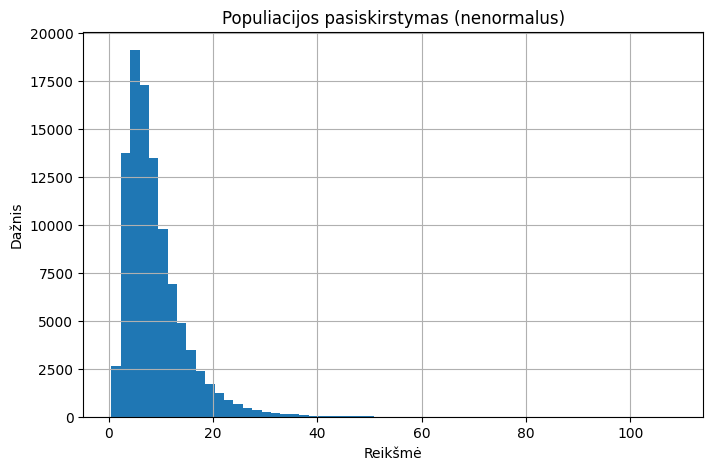

In [5]:

# Populiacijos histograma
plt.figure()
plt.hist(population, bins=60)
plt.title("Populiacijos pasiskirstymas (nenormalus)")
plt.xlabel("Reikšmė")
plt.ylabel("Dažnis")
plt.show()



## 3. Centrinės ribos teorema (CLT) – imčių vidurkių pasiskirstymas

Idėja: imant daug imčių ir skaičiuojant jų **vidurkius**, tie vidurkiai pasiskirstys **artimai normaliai**, net jei pradinė populiacija nenormali.


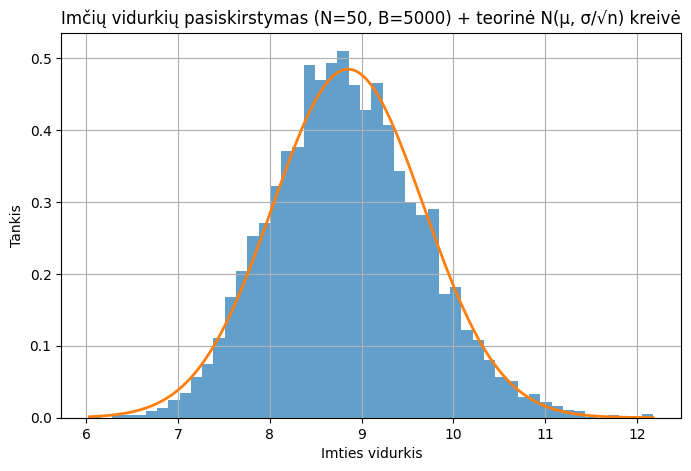

Imčių vidurkių empirinė vidurkis ≈ 8.848
Imčių vidurkių empirinė std ≈ 0.816
Teorinis std (σ/√n) ≈ 0.823


In [6]:

# CLT simuliacijos parametrai
N = 50        # imties dydis
B = 5000      # imitacijų skaičius (kiek imčių traukiame)

def sample_means(pop, n, b):
    means = np.empty(b)
    for i in range(b):
        sample = np.random.choice(pop, size=n, replace=True)
        means[i] = sample.mean()
    return means

means = sample_means(population, N, B)

# Histogramą palyginame su teorine N(mu, sigma/sqrt(n)) kreive
theo_mu = pop_mean
theo_sigma = pop_std / np.sqrt(N)

plt.figure()
count, bins, _ = plt.hist(means, bins=50, density=True, alpha=0.7)
x = np.linspace(min(means), max(means), 400)
pdf = stats.norm.pdf(x, loc=theo_mu, scale=theo_sigma)
plt.plot(x, pdf, linewidth=2)
plt.title(f"Imčių vidurkių pasiskirstymas (N={N}, B={B}) + teorinė N(μ, σ/√n) kreivė")
plt.xlabel("Imties vidurkis")
plt.ylabel("Tankis")
plt.show()

print(f"Imčių vidurkių empirinė vidurkis ≈ {means.mean():.3f}")
print(f"Imčių vidurkių empirinė std ≈ {means.std(ddof=1):.3f}")
print(f"Teorinis std (σ/√n) ≈ {theo_sigma:.3f}")



## 4. Pasikliautiniai intervalai (CI)

### 4.1. Kai populiacijos **σ žinomas** (naudojame z-kvantilį)
Formulė:  
\[ CI = \bar{x} \pm z_{\alpha/2}\cdot \frac{\sigma}{\sqrt{n}} \]

Žemiau parodysime vienos imties CI ir daugkartinių CI „padengimo“ (coverage) demonstraciją.


In [7]:

ALPHA = 0.05  # 95% CI
z = stats.norm.ppf(1 - ALPHA/2)

def ci_known_sigma(sample, sigma, alpha=ALPHA):
    n = len(sample)
    xbar = sample.mean()
    half = z * sigma / np.sqrt(n)
    return xbar - half, xbar + half, xbar

# Vienos imties pavyzdys
sample = np.random.choice(population, size=N, replace=True)
ci_lo, ci_hi, xbar = ci_known_sigma(sample, pop_std, ALPHA)
print(f"Imties vidurkis: {xbar:.3f}")
print(f"95% CI (žinomas σ): [{ci_lo:.3f}, {ci_hi:.3f}]")
print(f"Ar CI apima tikrą μ={pop_mean:.3f}? -> {ci_lo <= pop_mean <= ci_hi}")


Imties vidurkis: 6.999
95% CI (žinomas σ): [5.386, 8.612]
Ar CI apima tikrą μ=8.853? -> False


Padengimas (coverage) ~ 0.960 (tikėtina ~0.95)


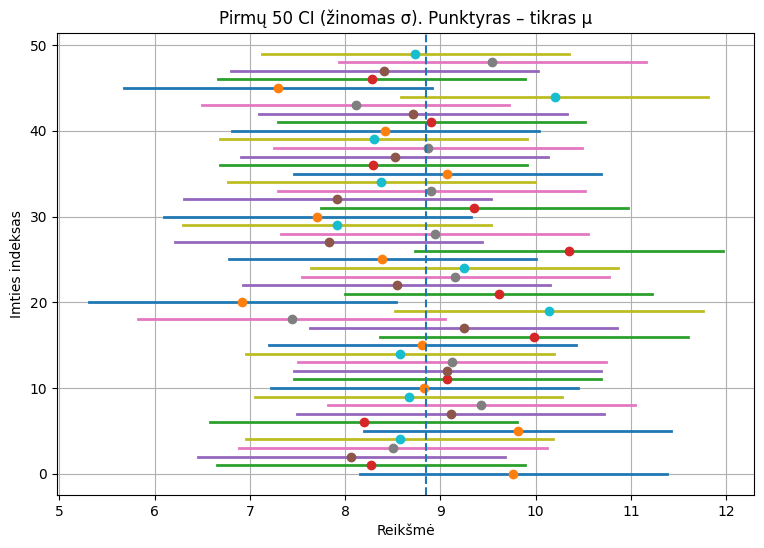

In [8]:

# Daugkartinių CI padengimo demonstracija (žinomas σ)
B_CI = 300
covers = 0
intervals = []

for _ in range(B_CI):
    s = np.random.choice(population, size=N, replace=True)
    lo, hi, xb = ci_known_sigma(s, pop_std, ALPHA)
    intervals.append((lo, xb, hi))
    if lo <= pop_mean <= hi:
        covers += 1

coverage_rate = covers / B_CI
print(f"Padengimas (coverage) ~ {coverage_rate:.3f} (tikėtina ~{1-ALPHA:.2f})")

# Vizualizacija: pirmų 50 intervalų
kiek = 50
xs = np.arange(kiek)
los = [intervals[i][0] for i in range(kiek)]
his = [intervals[i][2] for i in range(kiek)]
xbs = [intervals[i][1] for i in range(kiek)]

plt.figure(figsize=(9, 6))
for i in range(kiek):
    color = 'tab:blue' if (los[i] <= pop_mean <= his[i]) else 'tab:red'
    plt.plot([los[i], his[i]], [i, i], linewidth=2)
    plt.plot([xbs[i]], [i], marker='o')
plt.axvline(pop_mean, linestyle='--')
plt.title(f"Pirmų {kiek} CI (žinomas σ). Punktyras – tikras μ")
plt.xlabel("Reikšmė")
plt.ylabel("Imties indeksas")
plt.show()



### 4.2. Kai populiacijos **σ nežinomas** (naudojame t-skirstinį)

Formulė:  
\[ CI = \bar{x} \pm t_{\alpha/2,\,n-1}\cdot \frac{s}{\sqrt{n}} \]
kur **s** – imties standartinis nuokrypis, **df = n-1**.


In [9]:

def ci_unknown_sigma(sample, alpha=ALPHA):
    n = len(sample)
    xbar = sample.mean()
    s = sample.std(ddof=1)
    tcrit = stats.t.ppf(1 - alpha/2, df=n-1)
    half = tcrit * s / np.sqrt(n)
    return xbar - half, xbar + half, xbar

# Vienos imties pavyzdys (t-CI)
sample_t = np.random.choice(population, size=N, replace=True)
ci_lo_t, ci_hi_t, xbar_t = ci_unknown_sigma(sample_t, ALPHA)
print(f"Imties vidurkis: {xbar_t:.3f}")
print(f"95% CI (nežinomas σ, t): [{ci_lo_t:.3f}, {ci_hi_t:.3f}]")
print(f"Ar CI apima tikrą μ={pop_mean:.3f}? -> {ci_lo_t <= pop_mean <= ci_hi_t}")


Imties vidurkis: 7.838
95% CI (nežinomas σ, t): [6.473, 9.202]
Ar CI apima tikrą μ=8.853? -> True



## 5. Praktika: imčių vidurkių pasiskirstymo braižymas

Pakeiskite **N** ir **B** vertes ir pažiūrėkite, kaip keičiasi imčių vidurkių sklaida bei artėjimas prie normalumo.


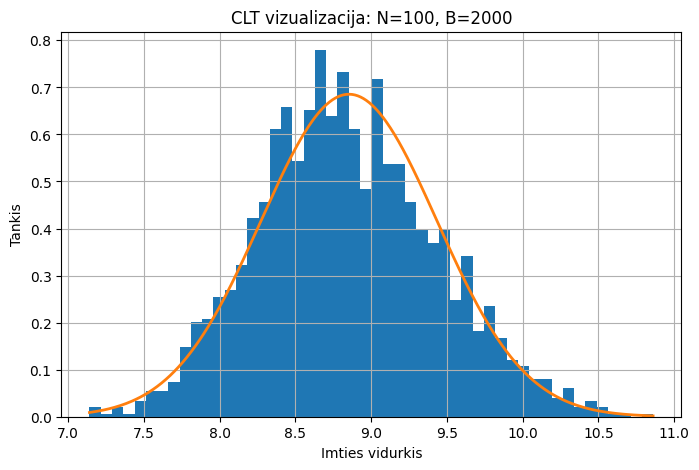

In [10]:

# Pabandykite pakeisti N=20, 30, 100 ir B=1000, 10000 ir dar kartą paleisti
N = 100
B = 2000
means = sample_means(population, N, B)

plt.figure()
plt.hist(means, bins=50, density=True)
x = np.linspace(min(means), max(means), 400)
pdf = stats.norm.pdf(x, loc=population.mean(), scale=population.std(ddof=0)/np.sqrt(N))
plt.plot(x, pdf, linewidth=2)
plt.title(f"CLT vizualizacija: N={N}, B={B}")
plt.xlabel("Imties vidurkis")
plt.ylabel("Tankis")
plt.show()



## 6. Mini užduotis (studentams)

**Užduotis:**  
1. Sugeneruokite populiaciją (pvz., pakeiskite `DIST` į `"exponential"` arba parametrus `MU`, `SIGMA`).  
2. Apskaičiuokite **populiacijos vidurkį**.  
3. Ištraukite **imtį** su dydžiu `n=50`.  
4. Apskaičiuokite **imties vidurkį** ir **95% CI** (t-CI).  
5. **Palyginkite**: ar CI apima tikrąjį populiacijos vidurkį?  
6. Nubraižykite imčių vidurkių histogramą ir palyginkite su teorine normalia.

👉 Pažymėtos **TODO** vietos žemiau:


Mano populiacijos μ ≈ 50.026
Imties vidurkis x̄ ≈ 55.289
95% t-CI: [38.155, 72.423]
Ar apima tikrą μ? -> True


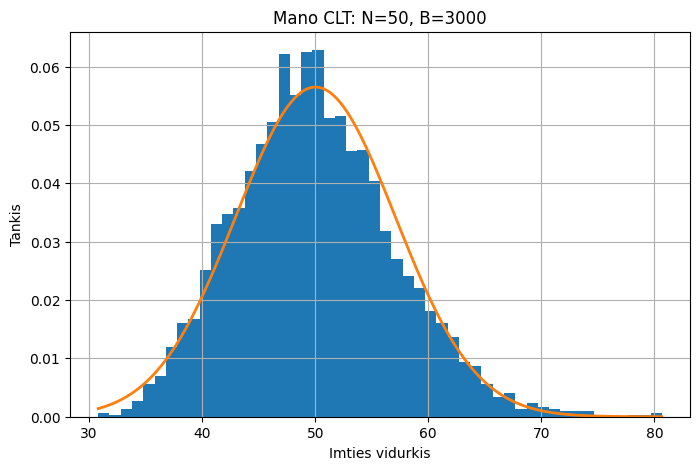

In [11]:

# TODO 1: Sugeneruokite savo populiaciją (galite pakeisti DIST, MU, SIGMA, LAMBDA)
my_population = generate_population(dist="exponential", mu=2.2, sigma=0.7)
my_pop_mean = my_population.mean()
print(f"Mano populiacijos μ ≈ {my_pop_mean:.3f}")

# TODO 2: Ištraukite imtį n=50
n = 50
my_sample = np.random.choice(my_population, size=n, replace=True)
my_xbar = my_sample.mean()
print(f"Imties vidurkis x̄ ≈ {my_xbar:.3f}")

# TODO 3: 95% CI su t-skirstiniu
lo, hi, xb = ci_unknown_sigma(my_sample, alpha=0.05)
print(f"95% t-CI: [{lo:.3f}, {hi:.3f}]")
print(f"Ar apima tikrą μ? -> {lo <= my_pop_mean <= hi}")

# TODO 4: Imčių vidurkių pasiskirstymo braižymas
N = 50
B = 3000
my_means = sample_means(my_population, N, B)

plt.figure()
plt.hist(my_means, bins=50, density=True)
xx = np.linspace(min(my_means), max(my_means), 400)
pdf2 = stats.norm.pdf(xx, loc=my_pop_mean, scale=my_population.std(ddof=0)/np.sqrt(N))
plt.plot(xx, pdf2, linewidth=2)
plt.title(f"Mano CLT: N={N}, B={B}")
plt.xlabel("Imties vidurkis")
plt.ylabel("Tankis")
plt.show()



## 7. Interpretacijos patarimai

- **CLT esmė:** imčių vidurkių skirstinys darosi „vis normalesnis“ didėjant imties dydžiui **n**.
- **CI 95 %** nereiškia, kad „tikimybė, jog μ yra šiame intervale, yra 95 %“ (μ yra fiksuotas).  
  Teisinga interpretacija: **jei kartotume ėmimą daug kartų**, ~95 % tokių intervalų apimtų tikrą **μ**.
- **t-skirstinį** naudokite, kai **σ nežinomas** ir **n mažas** (ypač n < 30).
- **Padengimas (coverage)** empiriškai parodo, ar mūsų procedūra veikia taip, kaip žadėta.
